<a href="https://colab.research.google.com/github/bloup1/Deep-Learning/blob/main/Summative_assessment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
## Summative assessment
### Coursework 3

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [ ]:
! pip install pydub==0.25.1 -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

Importing the data in Google Colab (Coursera is not reliable)

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Files.zip", 'r')
zip_ref.extractall("/cswk3")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
tf.config.list_physical_devices('GPU')

[]

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [ ]:
ds_whole = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling data/spoken_digit/spoken_digit/1.0.9.incompleteOVYFV5/spoken_digit-train.tfrecord*...:   0%|        …

Dataset spoken_digit downloaded and prepared to data/spoken_digit/spoken_digit/1.0.9. Subsequent calls will reuse this data.


In [ ]:
ds_whole.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

Add all of our library imports here.

In [ ]:

from tensorflow.keras.layers import (Layer, Input, Dense, GRU, Embedding, Conv2D, BatchNormalization, Activation, GlobalMaxPooling2D)


In [ ]:

! pip install librosa
! pip install tensorflow_io
import librosa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 22.1 MB/s eta 0:00:00


## EDA Attempt

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os import listdir
from os.path import join
from scipy.io import wavfile
import IPython.display as ipd

audio_list  = []
labels_list = []
for data in ds_whole:
    audio_list.append(data['audio'].numpy())
    labels_list.append(data['label'].numpy())
labels_array = np.array(labels_list)

The data consists of lable, audio and the filename

In [ ]:
data

{'audio': <tf.Tensor: shape=(2929,), dtype=int64, numpy=array([-1394, -1605,  1226, ...,    44,     5,    -6])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'9_george_33.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=9>}

In [ ]:
audio_rate = 8000

Let us start by playing one sound. This is a two, but there is quite a bit of noise in it.

In [ ]:
ipd.Audio(data["audio"].numpy(),rate=audio_rate)

In [ ]:


def show_length_distribution(signals, rate = 8000):
    """
    This function takes all the signals as a list and
    display their length distribution. The box shows the quartiles
    of the dataset while the whiskers extend to show the rest
    of the distribution
    """
    sample_times = [len(x)/rate for x in signals]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
    # Add a graph in each part
    sns.boxplot(x = sample_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sample_times, ax=ax_hist, bins = 'fd', kde = True)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    title = 'Audio signal lengths'
    x_label = 'Duration (seconds)'
    y_label = 'Count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label, fontsize=12)
    ax_hist.set_ylabel(y_label, fontsize=12)
    plt.show()
    return sample_times

What is the distribution of signal lenghts?

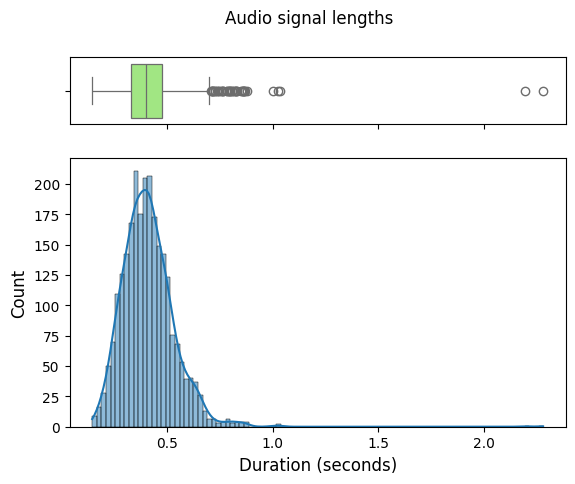

In [ ]:
unused = show_length_distribution(audio_list)

We notice that some signals can be very long (passed two seconds mark) compared to the bulk of the distribution which is less than 0.5 seconds in length.

There is equal presence of each digit:

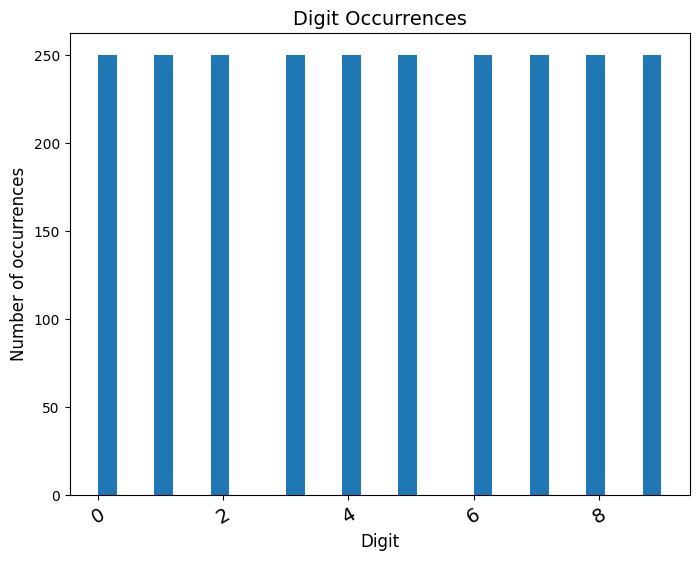

In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(8, 6))
num_bins = 30
n, bins, patches = ax.hist(labels_array, num_bins, density=False)
plt.xlabel('Digit', fontsize=12)
plt.ylabel('Number of occurrences', fontsize=12)
plt.title("Digit Occurrences", fontsize=14);
for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
                tick.label.set_rotation(30)

What is the longest signal?

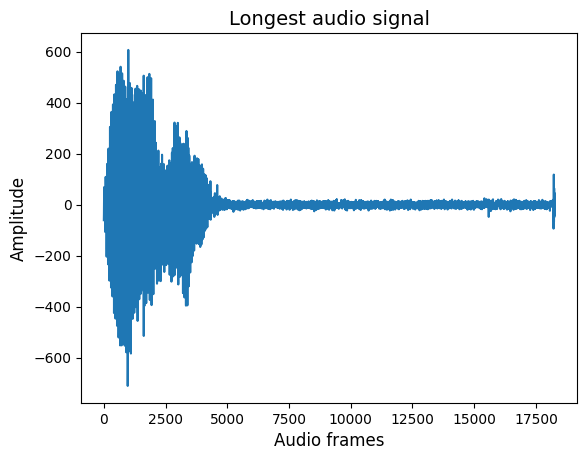

In [ ]:

Longest_audio = np.argmax([len(x) for x in audio_list])
plt.plot(audio_list[Longest_audio])
plt.title("Longest audio signal", fontsize=14);
plt.ylabel('Signal Strength', fontsize=12)
plt.xlabel('Audio frames', fontsize=12)

ipd.Audio(audio_list[Longest_audio], rate=audio_rate)

While the speaker takes his time to say the digit, we notice above that silence is filling the signal length. We shall trim it using librosa toolkit.

Let us now look at the shortest signal:

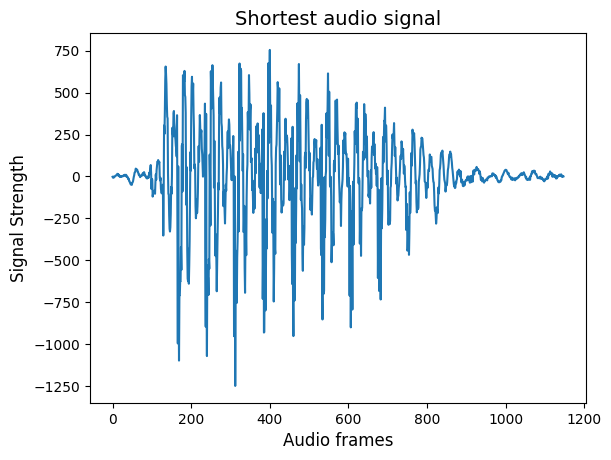

In [ ]:
Shortest_audio = np.argmin([len(x) for x in audio_list])
plt.plot(audio_list[Shortest_audio])
plt.title("Shortest audio signal", fontsize=14);
plt.ylabel('Signal Strength', fontsize=12)
plt.xlabel('Audio frames', fontsize=12)

ipd.Audio(audio_list[Shortest_audio], rate=audio_rate)

Let us now make a function to remove the silences when the top value of the signal exceeds

In [ ]:
from librosa.effects import trim
# from librosa's documentation:
#Trim leading and trailing silence from an audio signal.
#Silence is defined as segments of the audio signal that are top_db
#decibels (or more) quieter than a reference level, ref. By default,
#ref is set to the signal’s maximum RMS value

# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading
    silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float32)
    # trims the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

Let us now consider the trimmed signals:

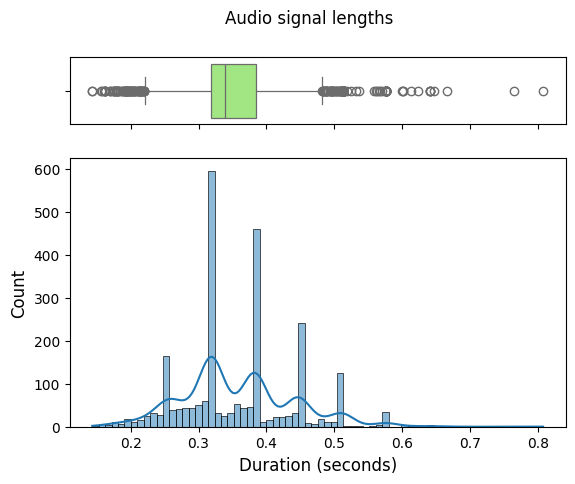

In [ ]:
audio_list_trimmed = [remove_silence(x) for x in audio_list]

show_length_distribution(audio_list_trimmed);

It makes sense to concentrate our effort on the trimmed version for the purpose of training the VQVAE. Let us now consider the challenge ahead. We'll compare the MEL spectrogram (representation in the frequency domain, which for this purpose will be summarized in a picture) to see if we can distinguish some patterns.

In [ ]:
# this is a "one"
audio_rate = 8000
one_sound = audio_list_trimmed[1]
# the sound one
ipd.Audio(one_sound, rate=audio_rate)

In [ ]:
# this is a "nine"
one_sound = audio_list_trimmed[2]
# the sound one
ipd.Audio(one_sound, rate=audio_rate)


In [ ]:
# this is another "nine"
another_one_sound = audio_list_trimmed[3]
ipd.Audio(another_one_sound, rate=audio_rate)

Let us now visualize the MEL spectrograms.

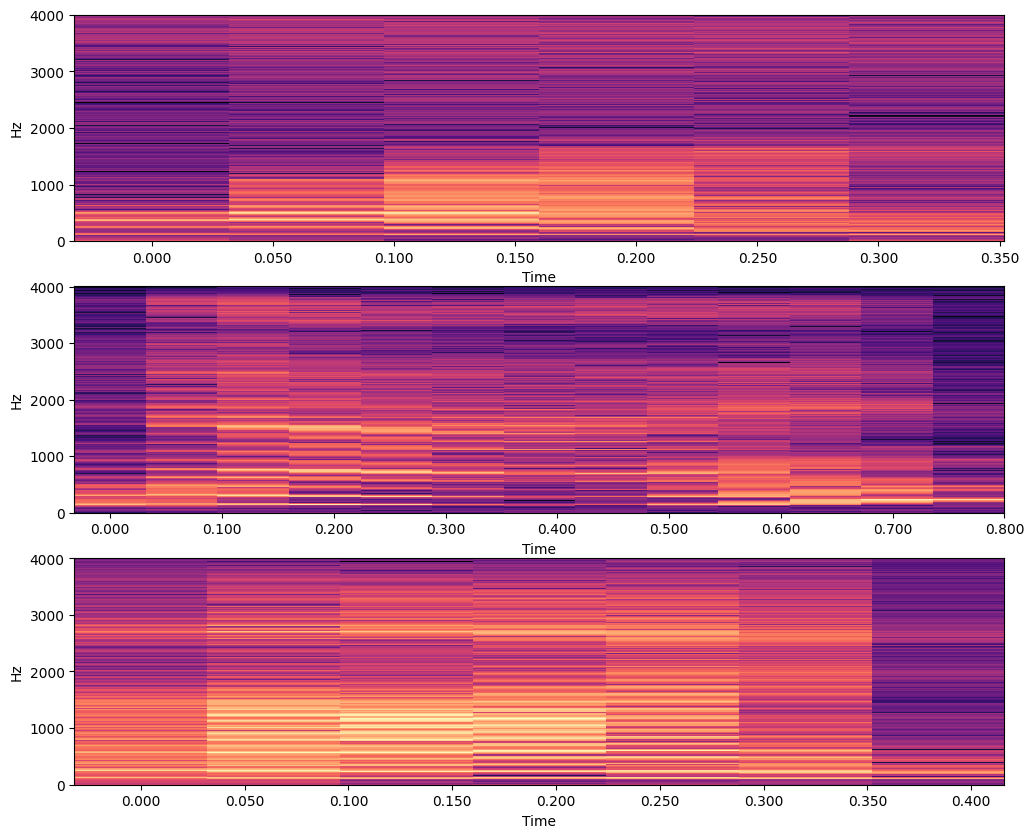

In [ ]:
#plt.figure(figsize=(12, 10))
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 10))

#plt.title("A Nine", fontsize=14);
stft1 = librosa.stft(audio_list_trimmed[1]*1.0)
Xdb1 = librosa.amplitude_to_db(abs(stft1))
#plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb1, sr=8000, x_axis='time', y_axis='hz', ax=ax1)
#ax1.colorbar()


#ax1.title("Another Nine", fontsize=14);
stft2 = librosa.stft(audio_list_trimmed[2]*1.0)
Xdb2 = librosa.amplitude_to_db(abs(stft2))
#plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb2, sr=8000, x_axis='time', y_axis='hz', ax=ax2)
#plt.colorbar()


#ax1.title("A One", fontsize=14);
stft3 = librosa.stft(audio_list_trimmed[3]*1.0)
Xdb3 = librosa.amplitude_to_db(abs(stft3))
#plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb3, sr=8000, x_axis='time', y_axis='hz', ax=ax3)
#plt.colorbar()


**This is a "one" followed by two "nines"**. There are not a lot of communalities between the two nines compared to the one.

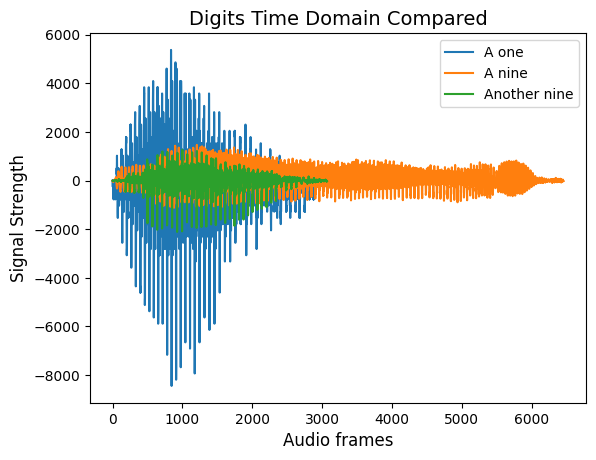

In [ ]:
plt.plot(audio_list_trimmed[1], label = "A one")
plt.plot(audio_list_trimmed[2], label = "A nine")
plt.plot(audio_list_trimmed[3], label = "Another nine")
plt.title("Digits Time Domain Compared", fontsize=14);
plt.ylabel('Signal Strength', fontsize=12)
plt.xlabel('Audio frames', fontsize=12)
plt.legend()
plt.show()

Even in the time domain, it is not easy to tell them apart.

## Data Processing

In this section, we will prepare the audio data for the training and testing of our deep neural network based architecture. We trimemd the signals to remove the silences as mentioned previously. We will also pad the audio signals to a common length in order to feed the VQVAE layers. Below we find the longest signal and append 0 to it up its length in addition to an offset to reach the next multiple of 8 in order to accomodate the 1D convolutions.

In [ ]:
# here we find the longest signal and will append 0 to it up to the next
# of 8 in order to accomodate the 1D convolutions
batch_size = 32
fill_to_multiple = 8
max_sound_trimmed = np.max([len(sound) for sound in audio_list_trimmed])
# we complete to the next multiple of 8
max_sound_trimmed = (fill_to_multiple-(max_sound_trimmed % fill_to_multiple))% fill_to_multiple+\
                        max_sound_trimmed

In [ ]:
max_sound_trimmed

6464

The maximum audio wave is now 6464 frames long. We pad and min-max normalize each signal to have it in a [0,1] range. We use numpy here since the dataset isn't big in either length or breadth.

In [ ]:
# we pad the audio signals with zeros up to that length
audio_signals_padded    = []
audio_signals_unpadded  = []
for sound in audio_list_trimmed:
    # min-max normalizing
    sound_scaled = (sound - np.min(sound))/(np.max(sound) - np.min(sound))
    audio_signals_padded.append(np.expand_dims(np.pad(sound_scaled,(0, max_sound_trimmed-len(sound)),
                           mode='constant'),axis=0))
    audio_signals_unpadded.append(sound_scaled)

# concatenate vertically the first array
# and horizontally the second array
audio_signals_padded = np.concatenate(audio_signals_padded)
audio_signals_unpadded = np.concatenate(audio_signals_unpadded)

In [ ]:
# we calculate the variance of our entire dataset
data_variance_nopadding = np.var(audio_signals_unpadded)
data_variance_nopadding

0.018428791

In [ ]:
whole_size = audio_signals_padded.shape[0]

In [ ]:
for a in tf.data.Dataset.from_tensor_slices(audio_signals_padded).take(1):
    print(a.shape)

(6464,)


In [ ]:
# we add an extra dimension, useful for the architectures that follow
def extend_sounds_dim(data):
    return data[...,tf.newaxis]

# we extend the dimension of the whole dataset
ds_whole_processed = tf.data.Dataset.\
    from_tensor_slices(audio_signals_padded).map(extend_sounds_dim)

def get_dataset_partitions_tf(whole_dataset, dataset_size, train_split=0.7,
                              val_split=0.15):
    """
    Takes the entire dataset, its size, train/validation ratios
    in order to split into train/validation/test sets. It also computes the
    variance of the dataset on the trimmed portion of the data
    """
    test_split = 1 - train_split - val_split
    assert (train_split + test_split + val_split) == 1

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = whole_dataset.take(train_size)
    val_ds = whole_dataset.skip(train_size).take(val_size)
    test_ds = whole_dataset.skip(train_size).skip(val_size)

    data_variance_nopadding = np.var(audio_signals_unpadded[0:train_size])

    return train_ds, val_ds, test_ds, data_variance_nopadding

In [ ]:
# calling the processing functions above
train_dataset, val_dataset, test_dateset, data_variance_nopadding =\
    get_dataset_partitions_tf(ds_whole_processed, whole_size)
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dateset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# the variance of our normalized, trimmed, padded training set
data_variance_nopadding

0.03198909

In [ ]:
# let us play again a sound to observe that
# it had been extended
train_check = 0
for elem in train_dataset.take(6):
    train_check = elem

ipd.Audio(tf.squeeze(train_check).numpy()[0], rate=audio_rate)

### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

We have the discrete version of the KL divergence:


\begin{align}
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) = \sum_{k}^{K} q_\phi(z = e_k\mid x)\log\left(\frac{q_\phi({z = e_k}\mid{x})}{p_\theta({z})}\right)
\end{align}

And we know that  $p_{\theta(z)}=\frac{1}{K}$ (uniform prior). Therefore we have:

\begin{align}
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) &= \log(K) \sum_{k}^{K} q_\phi(z = e_k\mid{x}) +  \sum_{k}^{K} q_\phi(z = e_k\mid x)\log\left(q_\phi(z = e_k \mid x)\right) \\
& = \log(K) + 0 = \log(K)
\end{align}
Since $f(u) = u \log(u) \text{ is zero at } x=0$ and since $\sum_{k}^{K} q_\phi(z = e_k\mid{x}) = 1$ as it is a probability distribution.

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [ ]:
# import useful layers and keras modules
from tensorflow.keras import layers
from tensorflow import keras


class RVQVectorQuantizer(layers.Layer):
    """
    This is the RVQ version of the Vector Quantizer class shown in keras
    see https://keras.io/examples/generative/vq_vae/

    """
    def __init__(self, num_codebook_vectors, codebook_vec_dim, beta=0.25,
                 num_quant_stages = 3,
                 decay = 0.99,
                 use_rd_restart = True,
                 thresh_rd_restarts_factor = 0.1,
                 epsilon = 1e-7, **kwargs):
        """
        num_codebook_vectors: the number of codebook vectors
        codebook_vec_dim: the dimension of each codebook vector
        beta: the weight of the commitment loss
        decay: the decay parameter for the EWMA
        num_quant_stages: the number of quantization stages
        use_rd_restart: whether to use random restarts (see https://arxiv.org/abs/2005.00341)
        thresh_rd_restarts_factor: a factor from >0 which control the minimum
        utilization of each codebook. Under a
        level = (num_codebooks/total_indices) * thresh_rd_restarts_factor, then the
        codebook needs to be replaced (this is applied across quantization stages)
        epsilon: to avoid dividing by zero when updating the EWMA raio

        """
        super().__init__(**kwargs)
        self.codebook_vec_dim           = codebook_vec_dim
        self.num_codebook_vectors       = num_codebook_vectors
        self.num_quant_stages           = num_quant_stages
        self.decay                      = decay
        self.epsilon                    = epsilon
        self.thresh_rd_restarts_factor  = thresh_rd_restarts_factor
        self.use_rd_restart             = use_rd_restart
        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the codebook vectors which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = [tf.Variable(
            initial_value = w_init(
                shape=(self.codebook_vec_dim, self.num_codebook_vectors), dtype="float32"
            ),
            trainable=False, # since we will use the moving average
            name="codebook_vec_vqvae_"+str(i),
            ) for i in range(self.num_quant_stages)]
        # we set those variables for the exponentially weighted moving averages
        self.ma_denominator     = [tf.Variable(tf.zeros((self.num_codebook_vectors)),trainable=False,
                                           name='ema_cluster_size_'+str(i)) for i in range(self.num_quant_stages)]
        self.ma_numerator       = [tf.Variable(self.embeddings[i], trainable=False,
                                           name='ema_sum_weights_'+str(i)) for i in range(self.num_quant_stages)]
        # useful for general statistic on codebook representation (if they are used or not) and for
        # random restarts
        self.indices_utilization= [tf.cast(tf.Variable(tf.zeros((self.num_codebook_vectors)), trainable=False,
                                           name='indices_usage_'+str(i)),tf.float32) for i in range(self.num_quant_stages)]

    def tf_count(self, t, val):
        """
        count the number of times element t is in val
        """
        elements_equal_to_value = tf.equal(t, tf.cast(val, tf.int32))
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        return count

    def update_utilization(self, flattened, current_codebk_num):
        num_codebooks   = self.num_codebook_vectors
        embedding_dim   = self.codebook_vec_dim
        embeddings      = self.embeddings
        total_indices   = tf.shape(flattened)[0]
        current_codebook        = tf.gather(embeddings,current_codebk_num)
        encoding_indices        = self.get_code_indices(flattened,current_codebook)
        count_indices           = tf.convert_to_tensor([self.decaytf_count(i, encoding_indices) for\
                                        i in range(num_codebooks)])
        self.indices_utilization[current_codebk_num].\
            assign(tf.cast((tf.squeeze(count_indices)/total_indices),tf.float32))

    def random_restartV2(self, flattened, current_codebk_num):
        """
        performs random restarts whereby each "dead" codebook is replaced by
        a randomly picked encoder vector (of dim batch_size x dim1 x dim2) amongst
        batch_size x dim1 (if dim2 == codebook_vec_dim)
        """
        num_codebooks   = self.num_codebook_vectors
        embedding_dim   = self.codebook_vec_dim
        embeddings      = self.embeddings
        # total number of indices (batch_size x dim1 typically)
        total_indices   = tf.shape(flattened)[0]
        # the threshold below which a codebook value is replaced by an encoder
        # value
        # ideally we would expect num_codebooks/total_indices utilization
        threshold_rd_restart    = tf.cast((num_codebooks/total_indices)*self.thresh_rd_restarts_factor,tf.float32)
        current_codebook        = tf.gather(embeddings,current_codebk_num)
        self.update_utilization(flattened, current_codebk_num)
        current_utilization = self.indices_utilization[current_codebk_num]
        indices_to_replace = tf.where(current_utilization < threshold_rd_restart*\
                                      tf.ones(tf.shape(current_utilization)))
        random_indices =  tf.random.uniform(shape=tf.shape(indices_to_replace),
                                    minval=tf.constant(0),
                                    maxval=total_indices-tf.constant(1),
                                    dtype=tf.dtypes.int32)
        updates = tf.gather_nd(flattened,random_indices)
        updated_cdbk = tf.transpose(tf.tensor_scatter_nd_update(\
                        tf.transpose(current_codebook),\
                        indices_to_replace, updates))
        return updated_cdbk

    def get_code_indices(self, flattened_inputs, codebook):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity     = tf.matmul(flattened_inputs,
                                    codebook)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(codebook ** 2, axis=0)
            - 2 * similarity
        )
        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

    def get_back_quantized(self, encoding_indices):
        encodings = tf.one_hot(encoding_indices, self.num_codebook_vectors)
        return tf.matmul(encodings, self.embeddings[-1],
                                       transpose_b=True)

    def call(self, encoder_out_vec, training = None):
        input_shape     = tf.shape(encoder_out_vec)
        flattened       = tf.reshape(encoder_out_vec, [-1, self.codebook_vec_dim])
        total_indices   = tf.shape(flattened)[0]

        residuals_init          = flattened
        quantized_init          = tf.zeros(tf.shape(flattened))
        residuals = residuals_init
        quantized = quantized_init
        for stage_number in range(self.num_quant_stages):
            current_embedding   = self.embeddings[stage_number]
            similarity          = tf.matmul(residuals,
                                        current_embedding)
            distances           = (tf.reduce_sum(residuals ** 2,
                                             axis=1, keepdims=True)
                                + tf.reduce_sum(current_embedding ** 2, axis=0)
                                - 2 * similarity)
            encoding_indices    = tf.cast(tf.argmin(distances, axis=1), tf.int32)
            encodings           = tf.one_hot(encoding_indices, self.num_codebook_vectors)
            quantized_temp      = tf.matmul(encodings,
                                       current_embedding,
                                       transpose_b=True)
            quantized = quantized + quantized_temp
            residuals = residuals - quantized_temp
            if training:
                #tf.print("is training")
                current_denominator     = tf.gather(self.ma_denominator,stage_number)
                current_numerator       = tf.gather(self.ma_numerator,stage_number)
                nit = tf.cast(tf.reduce_sum(encodings, 0), tf.float32)
                self.ma_denominator[stage_number].assign(self.decay*current_denominator + (1-self.decay)*nit)
                quantized_zij = tf.matmul(residuals, encodings, transpose_a = True)
                self.ma_numerator[stage_number].assign(self.decay*current_numerator+(1-self.decay)*quantized_zij)
                updated_numerator = tf.gather(self.ma_numerator,stage_number)
                updated_denominator = tf.gather(self.ma_denominator,stage_number)
                self.embeddings[stage_number].assign((updated_numerator+self.epsilon) /\
                                                            (updated_denominator+self.epsilon))
                if self.use_rd_restart:
                    updated_cb = self.random_restartV2(flattened, stage_number)
                    self.embeddings[stage_number].assign(updated_cb)
                else:
                    self.update_utilization(flattened, stage_number)

        quantized_reshaped = tf.reshape(quantized, input_shape)
        commitment_loss_rev = tf.reduce_mean((tf.stop_gradient(quantized_reshaped) - encoder_out_vec) ** 2)
        self.add_loss(self.beta * commitment_loss_rev)
        quantized_updated = encoder_out_vec + tf.stop_gradient(quantized_reshaped - encoder_out_vec)
        return quantized_updated




c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

In [ ]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

def get_vqvae(latent_dim=16, num_embeddings=12, use_rd_restart = False,
              beta=0.25, nq = 1, threshold_rd_restart = 0.01):
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, use_rd_restart = use_rd_restart,
                                  beta=beta, num_quant_stages = nq, thresh_rd_restarts_factor = threshold_rd_restart,
                                  name="vector_quantizer")
    #vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae"), vq_layer


get_vqvae()[0].summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_160 (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (RVQVecto  (None, 7, 7, 16)          408       
 rQuantizer)                                                     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48297 (188.66 KB)
Trainable params: 47889 (187.07 KB)
Non-trainable params: 408 (1.59 KB)
_________________________________________________________________


In [ ]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128,
                 use_rd_restart=False,beta=0.25, nq = 1,
                 threshold_rd_restart = 0.01,
                 **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.vqvae, self.vq_layer = get_vqvae(self.latent_dim,
                                              self.num_embeddings,
                                              use_rd_restart=use_rd_restart,
                                  beta=beta, nq = nq, threshold_rd_restart = threshold_rd_restart)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x, training = True)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) /\
                    self.train_variance
            )
            #print("stage f")
            #tf.print(self.vqvae.losses)
            #tf.print(reconstruction_loss)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        #print("stage g")
        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        #print("stage h")
        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        #print("stage i")
        #print(self.vq_loss_tracker.result())
        #print("stage j")
        #print(self.reconstruction_loss_tracker.result())
        #print("stage k")
        #print(self.total_loss_tracker.result())
        #print("stage l")
        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [ ]:
encoder = get_encoder(16)
vq_layer = RVQVectorQuantizer(10, 16, use_rd_restart = True,
                                  name="vector_quantizer",num_quant_stages=1)
example_image = x_train[0:2]#[np.newaxis,...]

vq_layer(encoder(example_image), training=True)

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance_mnist = np.var(x_train / 255.0)

In [ ]:
def reconstruction_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

vqvae_trainer = VQVAETrainer(data_variance_mnist, latent_dim=16, num_embeddings=64,
                             use_rd_restart=True,beta=0.25, nq = 3,
                            threshold_rd_restart = 0.00)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(),
                      loss=reconstruction_loss, metrics=['accuracy'])
history = vqvae_trainer.fit(x_train_scaled,
                            epochs=5,
                            batch_size=32)

Epoch 1/5
is training
is training
is training
is training
is training
is training
1875/1875 [==============================] - 27s 12ms/step - loss: 0.2499 - reconstruction_loss: 0.0925 - vqvae_loss: 0.0133
Epoch 2/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0668 - reconstruction_loss: 0.0395 - vqvae_loss: 0.0254
Epoch 3/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0598 - reconstruction_loss: 0.0332 - vqvae_loss: 0.0254
Epoch 4/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0515 - reconstruction_loss: 0.0277 - vqvae_loss: 0.0226
Epoch 5/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0448 - reconstruction_loss: 0.0245 - vqvae_loss: 0.0198


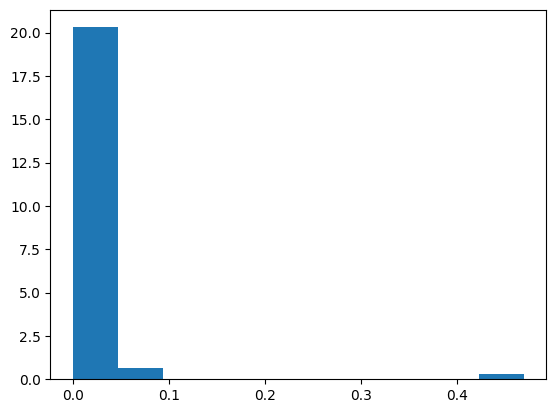

In [ ]:
util_last_layer = vqvae_trainer.vq_layer.indices_utilization[-1].numpy()
fig, ax = plt.subplots()
num_bins = 10
n, bins, patches = ax.hist(util_last_layer, num_bins, density=True)

In [ ]:
np.shape(util_last_layer[util_last_layer==0])[0]

37

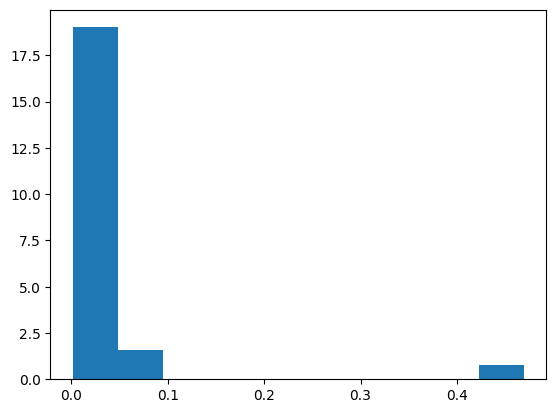

In [ ]:
util_last_non_zero = util_last_layer[util_last_layer>0]
#util_last_layer = vqvae_trainer.vq_layer.indices_utilization[-1].numpy()
fig, ax = plt.subplots()
num_bins = 10
n, bins, patches = ax.hist(util_last_non_zero, num_bins, density=True)

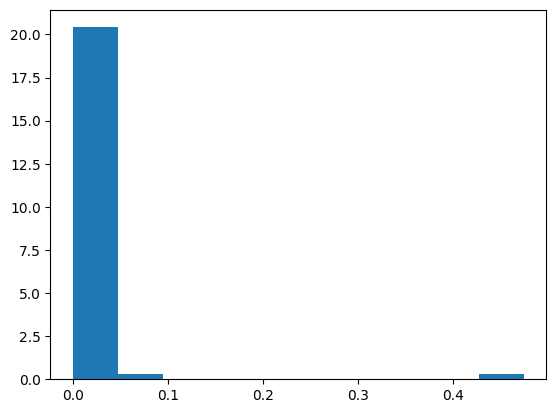

In [ ]:
fig, ax = plt.subplots()
num_bins = 10
n, bins, patches = ax.hist(util_last_layer, num_bins, density=True)


1/1 [==============================] - 0s 139ms/step


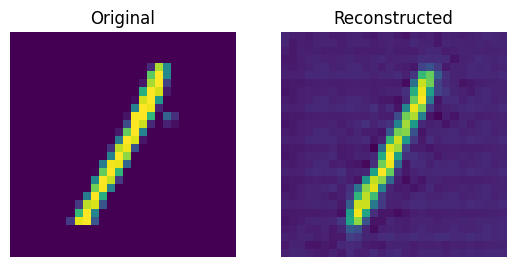

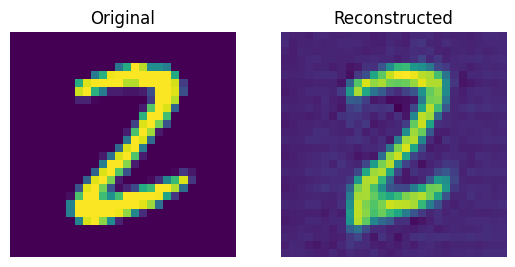

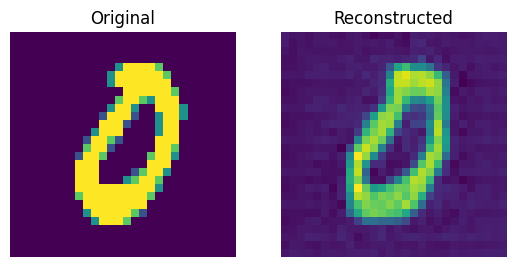

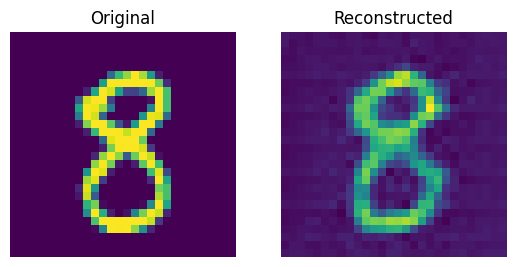

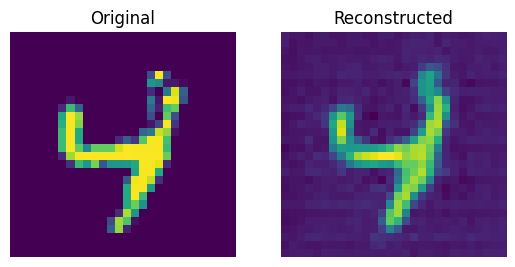

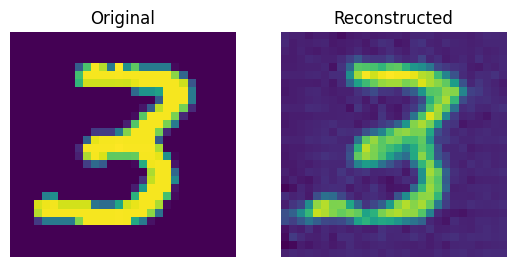

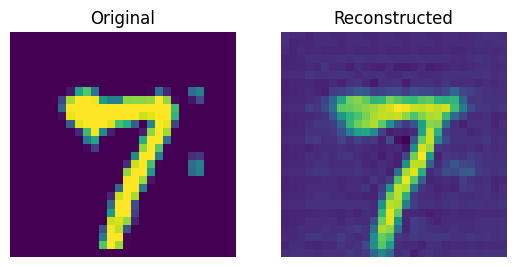

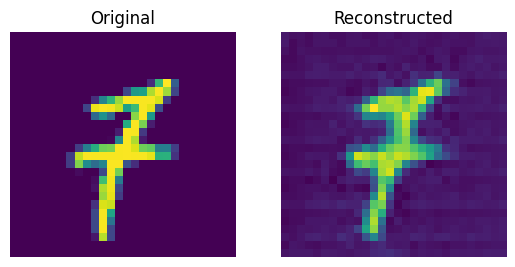

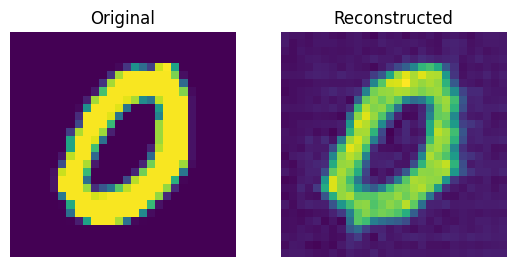

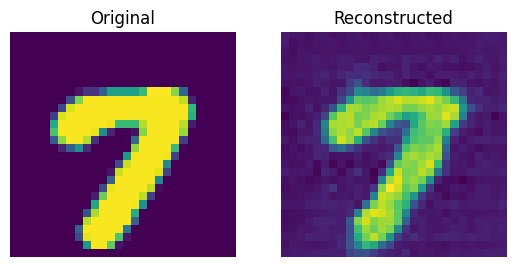

In [ ]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

We will need to create a few custom layers to handle the masking of padding values in the inputs.

In [ ]:
#RAVE: A variational autoencoder for fast and high-quality neural audio synthesis
#https://www.kaggle.com/code/basu369victor/generate-music-with-variational-autoencoder

In [ ]:
#https://yuehan-z.medium.com/introduction-to-vaes-in-ai-music-generation-d8e0cfc2245b

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow import keras
#spec[...,tf.newaxis]
#elem_extended = elem[...,tf.newaxis]


def get_encoder2(latent_dim=16):
    #encoder_inputs = keras.Input(shape=(18264, 1))
    encoder_inputs = keras.Input(shape=(None, 1))
    masked_input = tf.keras.layers.Masking(mask_value = 0.0)(encoder_inputs)

    out_layer1D16Causal = layers.Conv1D(16, 3, activation="relu", strides=2, dilation_rate = 1,
                      padding="causal")(
            masked_input
        )
    #x2 = BatchNormalization()(x1)
    out_layer1D32Dilat = layers.Conv1D(32, 3, activation="relu", strides=1, dilation_rate = 2,
                      padding="same")(
            out_layer1D16Causal
        )
    out_layer1D32 = layers.Conv1D(32, 3, activation="relu", strides=2, dilation_rate = 1, padding="same")(out_layer1D32Dilat)
    #x3d = Dropout(rate=0.7)(x3)
    #x5 = BatchNormalization()(x4)
    out_layer1D64 = layers.Conv1D(64, 3, activation="relu", strides=2, dilation_rate = 1, padding="same")(out_layer1D32)
    out_layer1DToLatent = layers.Conv1D(latent_dim, 1, padding="same")(out_layer1D64)
    encoder_outputs = BatchNormalization()(out_layer1DToLatent)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder2(latent_dim=16):
    #decoder_inputs = keras.Input(shape=(4566, 16))
    latent_inputs = keras.Input(shape=get_encoder2(latent_dim).output.shape[1:])
    out_layer1D64 = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, dilation_rate = 1, padding="same")(latent_inputs)
    out_layer1D32Dilat = layers.Conv1DTranspose(32, 3, activation="relu", strides=1, dilation_rate = 2, padding="same")(out_layer1D64)
    out_layer1D32 = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, dilation_rate = 1, padding="same")(out_layer1D32Dilat)
    out_layer1D16 = layers.Conv1DTranspose(16, 3, activation="relu", strides=2, dilation_rate = 1,
                      padding="same")(out_layer1D32)
    #out_layerBatchNorm = BatchNormalization()(out_layer1D16)
    out_layer1DFlattening = layers.Conv1DTranspose(1, 3, padding="same")(out_layer1D16)
    #out_layerBatchNorm = BatchNormalization()(out_layer1DFlattening)
    return keras.Model(latent_inputs, out_layer1DFlattening, name="decoder")


def get_vqvae2(num_embeddings=64, latent_dim=16, use_rd_restart=False,beta=0.25, nq = 1,
                 threshold_rd_restart = 0.01):

    #encoder_inputs = keras.Input(shape=(18264, 1))
    encoder_inputs = keras.Input(shape=(None, 1))
    encoder = get_encoder2(latent_dim=latent_dim)
    decoder = get_decoder2(latent_dim=latent_dim)
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim,
                                  use_rd_restart=use_rd_restart,
                                  num_quant_stages=nq,
                                  beta=beta,
                                  thresh_rd_restarts_factor = threshold_rd_restart,
                                  name="vector_quantizer")
    def call(inputs, training = False):
        encoder_outputs = encoder(inputs, training=training)
        quantized_latents = vq_layer(encoder_outputs, training=training)
        decoder_outputs = decoder(quantized_latents, training=training)
        return decoder_outputs

    class VQVAE(keras.Model):
        def call(self, inputs, training=False):
            print("is training?")
            print(training)
            return call(inputs, training=training)


    return VQVAE(inputs=encoder_inputs, outputs=call(encoder_inputs) , name="vq_vae"), encoder, vq_layer, decoder

class VQVAETrainer2(keras.models.Model):
    def __init__(self, train_variance, latent_dim=16, num_embeddings=128,
                 use_rd_restart=False,beta=0.25, nq = 1,
                 threshold_rd_restart = 0.01,
                 **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae, self.encoder, self.vq_layer, self.decoder = get_vqvae2(self.num_embeddings,
                                                                           self.latent_dim,
                                                                           use_rd_restart=use_rd_restart,
                                                                           beta=beta, nq =nq, threshold_rd_restart = threshold_rd_restart)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x, training=True)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) /\
                self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)
        print("in train step")
        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

    def test_step(self, data):

        # add losses for test case

        x_vector = data
        reconstructions = self.vqvae(x_vector, training = False)
        reconstruction_loss = tf.reduce_mean((x_vector - reconstructions) ** 2) / self.train_variance
        total_loss = reconstruction_loss + sum(self.vqvae.losses)

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [ ]:
vqvae2, encoder, vq_layer, decoder = get_vqvae2(num_embeddings=64, latent_dim=16, use_rd_restart=False,
               nq=3)


In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_462 (InputLayer)      [(None, None, 1)]         0         
                                                                 
 masking_91 (Masking)        (None, None, 1)           0         
                                                                 
 conv1d_550 (Conv1D)         (None, None, 16)          64        
                                                                 
 conv1d_551 (Conv1D)         (None, None, 32)          1568      
                                                                 
 conv1d_552 (Conv1D)         (None, None, 32)          3104      
                                                                 
 conv1d_553 (Conv1D)         (None, None, 64)          6208      
                                                                 
 conv1d_554 (Conv1D)         (None, None, 16)          1040

In [ ]:
for elem_test in train_dataset.take(1):
    output_test = vqvae2(elem_test)

print(output_test.shape)

print(elem_test.shape)

is training?
False
(32, 6464, 1)
(32, 6464, 1)


In [ ]:
print(encoder(elem_test).shape)

(32, 808, 16)


In [ ]:
print(decoder(vq_layer(encoder(elem_test))).shape)

(32, 6464, 1)


In [ ]:
data_variance_nopadding

0.018428791

In [ ]:
newpath = './model_saved_data/'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
import os
from pathlib import Path
# setting up the files
checkpoint_dir = Path('./model_saved_data/')
checkpoint_file = Path('./model_saved_data/model_checkpoint')
modelsaved_file = Path('./model_saved_data/full_model')
# CSV logger which records training and validation metrics per epoch
csv_logger = tf.keras.callbacks.CSVLogger(
    Path('./model_saved_data/training.log'), separator=',', append=False
)

In [ ]:
import os
from pathlib import Path

def reconstruction_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

vqvae_trainer = VQVAETrainer2(data_variance_nopadding, latent_dim=16, num_embeddings=128,
                              use_rd_restart=True,beta=0.25, nq = 10,
                                threshold_rd_restart = 0.20)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(),
                      loss=reconstruction_loss, metrics=['val_loss'])

# CSV logger which records training and validation metrics per epoch
csv_logger = tf.keras.callbacks.CSVLogger(
    Path('./model_saved_data/training.log'), separator=',', append=False
)
# initialize the checkpoint object
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    # we'll only save the model weights
    save_weights_only=True,
    monitor='val_loss',
    # save every epoch if needed
    save_freq = 'epoch',
    mode='max',
    # only keep the best model
    save_best_only=True)

#early_stopping = keras.callbacks.EarlyStopping(
#                monitor="val_loss",
#                patience=10)

In [ ]:


#vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam(0.0005))
#vqvae_trainer.fit(train_data, epochs=100, validation_data=val_data,
#                  callbacks = [early_stopping])

history = vqvae_trainer.fit(train_dataset,
                            validation_data=val_dataset,
                            epochs=1,
                            callbacks=[model_checkpoint_callback, csv_logger],
                            batch_size=batch_size)

is training?
True
in train step
is training?
True
in train step
55/55 [==============================] - ETA: 0s - loss: 2.5738 - reconstruction_loss: 1.1213 - vqvae_loss: 0.0269is training?
False
55/55 [==============================] - 25s 111ms/step - loss: 2.5482 - reconstruction_loss: 1.1213 - vqvae_loss: 0.0268 - val_loss: 3.4029 - val_reconstruction_loss: 3.3714 - val_vqvae_loss: 0.0315


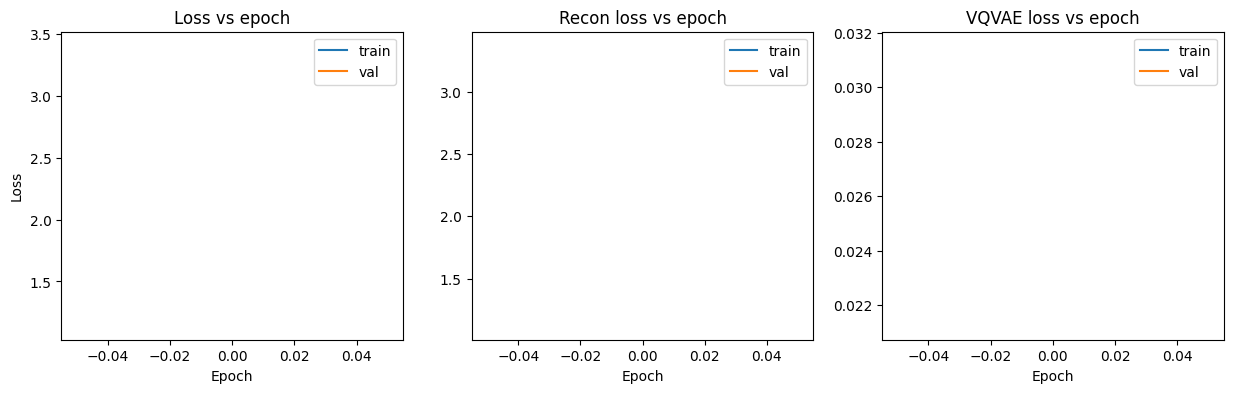

In [ ]:
# Plot the learning curves

fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='train')
plt.plot(history.history['val_reconstruction_loss'], label='val')
plt.xlabel("Epoch")
plt.title("Recon loss vs epoch")
plt.legend()

fig.add_subplot(1, 3, 3)
plt.plot(history.history['vqvae_loss'], label='train')
plt.plot(history.history['val_vqvae_loss'], label='val')
plt.xlabel("Epoch")
plt.title("VQVAE loss vs epoch")
plt.legend()

plt.show()

In [ ]:
for sample_test in test_dataset.take(1):
    sample_test


trained_vqvae_model = vqvae_trainer.vqvae
reconstructions_test = trained_vqvae_model.predict(sample_test)

is training?
False
1/1 [==============================] - 1s 506ms/step


In [ ]:
tf.squeeze(reconstructions_test)[0]

index_test = 7

Audio(tf.squeeze(reconstructions_test)[index_test],rate=8000)

In [ ]:
sample_test

Audio(tf.squeeze(sample_test)[index_test],rate=8000)

In [ ]:
chromogram1 = librosa.feature.chroma_stft(y=tf.squeeze(reconstructions_test)[index_test].numpy(), sr=8000);
chromogram2 = librosa.feature.chroma_stft(y=tf.squeeze(sample_test)[index_test].numpy(), sr=8000);


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_file)
vqvae_trainer.load_weights(latest)

AttributeError: 'NoneType' object has no attribute 'endswith'

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors.

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

In [ ]:
# causal mask on conv1d
# dilated kernels
# plot reconstruction on top of each other - normalize and plot
# FiLM layer to perform denoising
# use an rnn for the last part
# masking not handled in this implementation
# look into early stopping



# how to get the data variance
# the training pipeline will mutate the objects (encoder)

# report:
#   hyper-parameter tuning
#   start with simple model
#   then complexify the model
#   by reading these papers

# random restart or dropouts

In [ ]:
encoder = vqvae_trainer.encoder
decoder = vqvae_trainer.decoder

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_458 (InputLayer)      [(None, None, 1)]         0         
                                                                 
 masking_89 (Masking)        (None, None, 1)           0         
                                                                 
 conv1d_540 (Conv1D)         (None, None, 16)          64        
                                                                 
 conv1d_541 (Conv1D)         (None, None, 32)          1568      
                                                                 
 conv1d_542 (Conv1D)         (None, None, 32)          3104      
                                                                 
 conv1d_543 (Conv1D)         (None, None, 64)          6208      
                                                                 
 conv1d_544 (Conv1D)         (None, None, 16)          1040

In [ ]:
vq_layer = vqvae_trainer.vq_layer

In [ ]:
vq_layer.embedding_dim

16

In [ ]:
vq_layer.num_embeddings

128

In [ ]:
vq_layer.beta

0.25

In [ ]:
vq_layer.use_rd_restart

True

In [ ]:
encoder = vqvae_trainer.encoder
vq_layer = vqvae_trainer.vq_layer




def get_encoding_indices(elem):
    encoder_output = encoder(elem)
    end_shape = tf.shape(encoder(elem))[0:2]
    flattened = tf.reshape(encoder_output, [-1, vq_layer.codebook_vec_dim])
    encoding_indices_flat = vq_layer.get_code_indices(flattened,
                                             vq_layer.embeddings[-1])
    return tf.reshape(encoding_indices_flat,end_shape)


train_codebooks = train_dataset.map(get_encoding_indices)
val_codebooks = val_dataset.map(get_encoding_indices)
test_codebooks = test_dataset.map(get_encoding_indices)

In [ ]:
for a in test_codebooks.take(1):
    print(a)

tf.Tensor(
[[ 64  86  86 ...   1   1   1]
 [ 64 113 123 ...   1   1   1]
 [ 64 106 106 ...   1   1   1]
 ...
 [ 64  85 123 ...   1   1   1]
 [ 64  85  25 ...   1   1   1]
 [ 64 113 113 ...   1   1   1]], shape=(32, 808), dtype=int64)


In [ ]:
train_cb_list   = []
val_cb_list     = []
test_cb_list    = []
for elem in train_codebooks:
    train_cb_list.append(elem.numpy())
for elem in val_codebooks:
    val_cb_list.append(elem.numpy())
for elem in test_codebooks:
    test_cb_list.append(elem.numpy())

In [ ]:
train_cb_onematrix  = np.concatenate(train_cb_list)
val_cb_onematrix    = np.concatenate(val_cb_list)
test_cb_onematrix   = np.concatenate(test_cb_list)

In [ ]:
test_cb_list[0].shape

(32, 808)

In [ ]:
np.unique(test_cb_onematrix)

array([  0,   1,   4,   6,   7,   8,   9,  11,  16,  17,  20,  21,  25,
        27,  29,  31,  32,  37,  41,  42,  43,  46,  50,  52,  53,  54,
        57,  60,  63,  64,  66,  70,  74,  76,  78,  79,  80,  81,  84,
        85,  86,  88,  91,  92,  93,  96,  97, 103, 104, 106, 109, 110,
       112, 113, 114, 115, 117, 121, 122, 123, 124, 125])

In [ ]:
np.unique(train_cb_onematrix)

array([  0,   1,   4,   6,   7,   8,   9,  11,  16,  17,  20,  21,  25,
        27,  29,  31,  32,  37,  41,  42,  43,  46,  50,  52,  53,  54,
        57,  60,  63,  64,  66,  70,  74,  76,  78,  79,  80,  81,  84,
        85,  86,  88,  91,  92,  93,  96,  97, 103, 104, 106, 109, 110,
       112, 113, 114, 115, 117, 121, 122, 123, 124, 125])

In [ ]:
len(np.unique(test_cb_onematrix))

62

In [ ]:
len(np.unique(train_cb_onematrix))

62

In [ ]:
train_slice_cb = tf.data.Dataset.from_tensor_slices(train_cb_onematrix)
val_slice_cb = tf.data.Dataset.from_tensor_slices(val_cb_onematrix)
test_slice_cb = tf.data.Dataset.from_tensor_slices(test_cb_onematrix)

for element in test_slice_cb.take(1):
  print(element)

tf.Tensor(
[ 64  86  86  86  86  86  86  86  86  57  86  86  86  86  86  57  86  86
  86  86  86  86  86  57  86  86  86  86  86  86  57  86  86  86  43  25
  70  17  43  86  86  43  43 109  32  43  25  86  86  57  70  78   9  43
 112  86 121 112 109  32  53 112 104  53 112 104   0  70  64  53  86  25
 112  78  64  17  53  25 104  86  53   0  57  64 104  53  43  70  20  64
 104  53  17  17 112  86   0  53  25  43 112  25 112 109  64  64 112 104
  86  86 122  96  86 104  53 121  17  86 122  96  53 104  53  43  43 112
  86   0  53  86  53  57 112 112  86 117  53  86  53  57  25 112  25  20
  25  86  53 121 121  86  57 109  32 112  25 104  86  86  86  86  70  64
  86  86  57  43  25  86  86  70  64  43  86  25  43  86  86  43 109  64
 121  86 104  43  86  86  43 104  53  86  25  53 112  57  86  86  43 112
  42  43  86  43  86  57  86  86  57  86   9  43 112  42  86  57  86  57
  86  16  25  57  43 104  43  86  86  86  86  60  25  43  86 104  86  25
  86  86  86  60  25  43  86  57  43  86

In [ ]:
def inputs_and_targets(batch):
    inputs = batch[:-1]
    targets = batch[1:]
    return inputs, targets

batch_size_codebook = 32

train_ds_ar = train_slice_cb.map(inputs_and_targets).batch(batch_size_codebook)
val_ds_ar   = val_slice_cb.map(inputs_and_targets).batch(batch_size_codebook)
test_ds_ar  = test_slice_cb.map(inputs_and_targets).batch(batch_size_codebook)

In [ ]:
for elem in train_ds_ar.take(1):
    print(elem[0].shape)

(32, 807)


In [ ]:
vq_layer.num_embeddings

128

In [ ]:
from tensorflow.keras.layers import Dropout

def get_model(vocab_size, embedding_dim, gru_units):
    """
    This function takes a vocabulary size and batch size, and builds and returns a
    Sequential model according to the above specification.
    """

    inputs = tf.keras.layers.Input(shape=(None,), name="token_input")
    embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                                          mask_zero=True, name='embedding')(inputs)
    #postGRU, state = tf.keras.layers.GRU(units=gru_units, return_sequences=True,
    #                               return_state=True, name='gru2')(embedding)
    postLSTM, final_memory_state, final_carry_state = tf.keras.layers.LSTM(units=gru_units, return_sequences=True,
                                         return_state=True, name='lstm')(embedding)
    postDropoutLayer = Dropout(rate=0.2)(postLSTM)
    preds = tf.keras.layers.Dense(vocab_size, name='preds')(postDropoutLayer)
    model = tf.keras.Model(inputs=inputs, outputs=[preds, final_memory_state])

    losses = [
        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        None
    ]
    model.compile(optimizer='adam',
                  metrics=[['sparse_categorical_accuracy'], []],
                  loss=losses)
    return model


rnn_model = get_model(vocab_size = vq_layer.num_embeddings, embedding_dim = 128, gru_units = 512)
rnn_model.summary()

history = rnn_model.fit(train_ds_ar, validation_data=val_ds_ar, epochs=10,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         16384     
                                                                 
 lstm (LSTM)                 [(None, None, 512),       1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
 dropout_10 (Dropout)        (None, None, 512)         0         
                                                                 
 preds (Dense)               (None, None, 128)         65664     
                                                                 
Total params: 1394816 (5.32 MB)
Trainable params: 1394816 

KeyboardInterrupt: 

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,), name="token_input")
embedding = tf.keras.layers.Embedding(input_dim=128, output_dim=128,
                                        mask_zero=True, name='embedding')(inputs)
whole_seq_output, final_memory_state, final_carry_state = tf.keras.layers.LSTM(units=256, return_sequences=True,
                                return_state=True, name='gru2')(embedding)
model = tf.keras.Model(inputs=inputs, outputs=[whole_seq_output, final_memory_state])

In [ ]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         16384     
                                                                 
 gru2 (LSTM)                 [(None, None, 256),       394240    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 410624 (1.57 MB)
Trainable params: 410624 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(a)
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

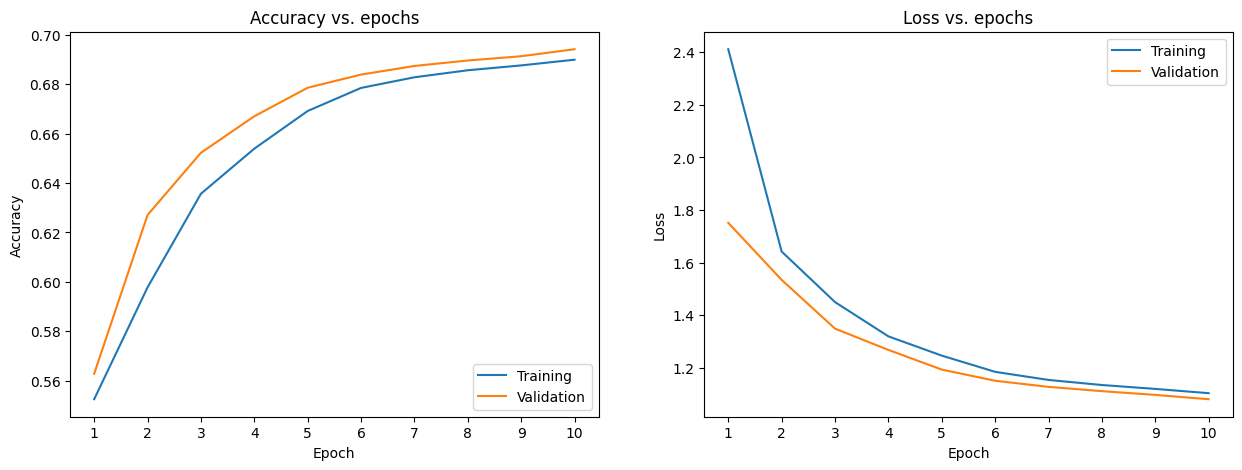

In [ ]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['preds_sparse_categorical_accuracy'])
plt.plot(history.history['val_preds_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history.history['preds_sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:

for elem in test_ds_ar.take(3):
    input_codebook = elem

In [ ]:
a_test_codebook = input_codebook[0][0]

In [ ]:
codebooklength = max_sound_trimmed/2/2-1
codebooklength

1615.0

In [ ]:
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_457 (InputLayer)      [(None, None, 1)]         0         
                                                                 
 encoder (Functional)        (None, None, 16)          12048     
                                                                 
 vector_quantizer (RVQVecto  (None, None, 16)          43520     
 rQuantizer)                                                     
                                                                 
 decoder (Functional)        (None, None, 1)           14017     
                                                                 
Total params: 69585 (271.82 KB)
Trainable params: 26033 (101.69 KB)
Non-trainable params: 43552 (170.12 KB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow import keras
#spec[...,tf.newaxis]
#elem_extended = elem[...,tf.newaxis]


def get_encoder2(latent_dim=16):
    #encoder_inputs = keras.Input(shape=(18264, 1))
    encoder_inputs = keras.Input(shape=(None, 1))
    masked_input = tf.keras.layers.Masking(mask_value = 0.0)(encoder_inputs)
    out_layer1D16Causal = layers.Conv1D(16, 3, activation="relu", strides=2, dilation_rate = 1,
                      padding="causal")(
            masked_input
        )
    #x2 = BatchNormalization()(x1)
    out_layer1D32Dilat = layers.Conv1D(32, 3, activation="relu", strides=1, dilation_rate = 2,
                      padding="same")(
            out_layer1D16Causal
        )
    out_layer1D32 = layers.Conv1D(32, 3, activation="relu", strides=2, dilation_rate = 1, padding="same")(out_layer1D32Dilat)
    #x3d = Dropout(rate=0.7)(x3)

In [ ]:
def sample_token(model, token_sequence, initial_state=None):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    h = token_sequence
    updated_state = None
    for i, layer in enumerate(model.layers):
        if i == 2:
            h, updated_state = layer(h, initial_state=initial_state)
        else:
            h = layer(h)
    final_step = h[:, -1, :]  # (batch_size, num_tokens)
    samples = tf.random.categorical(final_step, 1)  # (batch_size, 1)
    return samples, updated_state

samples, updated_state = sample_token(rnn_model, tf.constant([[30, 2, 24], [16, 12, 33]]))


def generate_codebook(model, input_codebook, num_generation_steps,
                  num_embeddings=128, sample_token=sample_token):
    """
    This function takes a model object, a seed string, a TextVectorization object and a
    number of steps to generate characters as arguments. It should generate text
    according to the above directions and return the extended string.
    """
    token_sequence = input_codebook[tf.newaxis, ...]  # (1, seq_length)
    input_sequence = token_sequence
    initial_state = None
    for _ in range(num_generation_steps):
        sample, updated_state = sample_token(model, input_sequence, initial_state=initial_state)
        token_sequence = tf.concat((token_sequence, sample), axis=1)
        input_sequence = sample
        initial_state = updated_state

    return token_sequence

start_length = 300

output_seq = generate_codebook(rnn_model, a_test_codebook[0:start_length],
                  1615 - start_length,128, sample_token)

ValueError: too many values to unpack (expected 2)

In [ ]:
output_seq.numpy()

array([[115,   3,  96, ...,   1,   1,   1]])

In [ ]:
a = tf.squeeze(decoder(vq_layer.get_back_quantized(output_seq))).numpy()

Audio(a,rate=8000)

In [ ]:
full_sound = tf.concat([a_test_codebook,[tf.cast(1,tf.int64)]],0)[tf.newaxis,...]

b = tf.squeeze(decoder(vq_layer.get_back_quantized(full_sound))).numpy()

Audio(b,rate=8000)

In [ ]:
full_sound

<tf.Tensor: shape=(1, 4566), dtype=int64, numpy=array([[116, 116, 116, ..., 116, 116,   1]])>

In [ ]:
tf.concat([input_codebook[0][0],[tf.cast(1,tf.int64)]],0)[tf.newaxis,...]

<tf.Tensor: shape=(1, 4566), dtype=int64, numpy=array([[116, 116, 116, ..., 116, 116,   1]])>

In [ ]:
output_seq

<tf.Tensor: shape=(1, 4566), dtype=int64, numpy=array([[116, 116, 116, ..., 123, 123, 123]])>

### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices.

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**